_Lambda School Data Science — Tree Ensembles_ 

This sprint, your project is about water pumps in Tanzania. Can you predict which water pumps are faulty?

# Random Forests, Ordinal Encoding

### Objectives
- do feature engineering with dates
- use scikit-learn for random forests
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth
- do ordinal encoding with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models

### Summary 

#### Try Tree Ensembles when you do machine learning with labeled, tabular data
- "Tree Ensembles" means Random Forest or Gradient Boosting models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or boosting (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. Gradient Boosting's advantage: may get better predictive accuracy.

#### One-hot encoding isn’t the only way, and may not be the best way, of categorical encoding for tree ensembles.
- For example, tree ensembles can work with arbitrary "ordinal" encoding! (Randomly assigning an integer to each category.) Compared to one-hot encoding, the dimensionality will be lower, and the predictive accuracy may be just as good or even better.


### Libraries

#### category_encoders
- Local, Anaconda: `conda install -c conda-forge category_encoders`
- Google Colab: `pip install category_encoders`

#### graphviz
- Local, Anaconda: `conda install python-graphviz`
- Google Colab:  `!pip install graphviz` `!apt-get install graphviz`

## Solution example
- Do feature engineering with dates
- Clean data with outliers
- Impute missing values
- Use scikit-learn for decision trees
- Get and interpret feature importances of a tree-based model

In [1]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = LOCAL

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    X = X.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [2]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [3]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,years
43360,0.0,NaN,NaN,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,...,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,7,27,2011
7263,500.0,Rc Church,2049.0,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,...,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3,23,3
2486,25.0,Donor,290.0,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,...,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011,3,7,1
313,0.0,Government Of Tanzania,NaN,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,...,shallow well,shallow well,groundwater,other,other,non functional,2011,7,31,2011
52726,0.0,Water,NaN,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,...,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,2011,3,10,2011


In [4]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    DecisionTreeClassifier(max_depth=20, random_state=42)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-03.csv', index=False)

Validation Accuracy 0.7712121212121212


In [5]:
encoder = ce.OneHotEncoder(use_cat_names=True);
train_encoded = encoder.fit_transform(X_train);

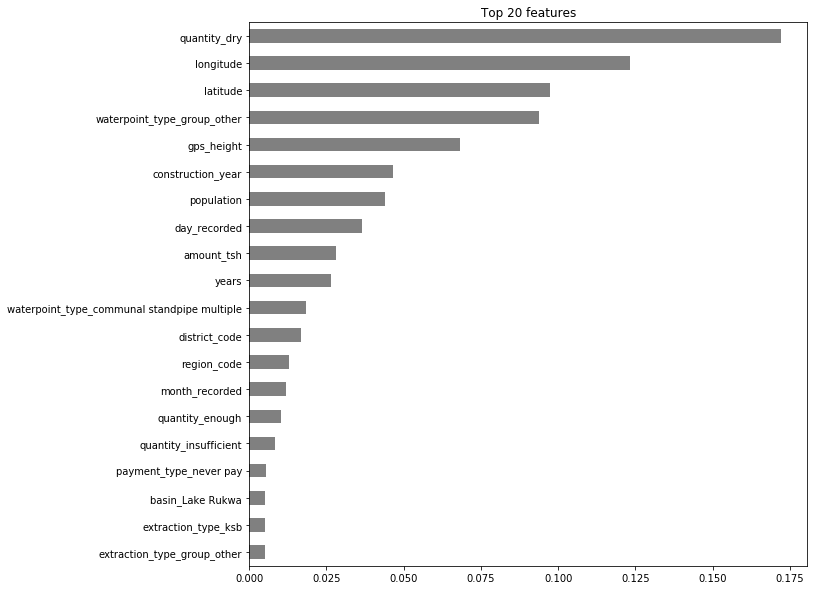

In [6]:
# Get feature importances
encoder = pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['decisiontreeclassifier']
feature_names = encoder.transform(X_val).columns
importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [7]:
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

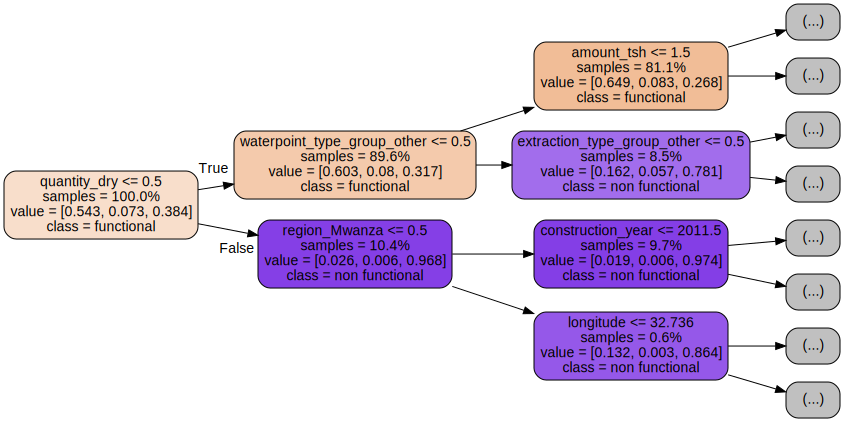

In [8]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, 
                           out_file=None, 
                           max_depth=2, 
                           feature_names=feature_names, 
                           class_names=tree.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rotate=True, 
                           rounded=True)

graphviz.Source(dot_data)

## Use scikit-learn for random forests

[Scikit-Learn User Guide: Random Forests](https://scikit-learn.org/stable/modules/ensemble.html#random-forests) 

In [9]:
# TODO

from sklearn.ensemble import RandomForestClassifier;

# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-04.csv', index=False)

Validation Accuracy 0.8087542087542088


In [10]:
encoder = pipeline.named_steps['onehotencoder'];
encoded_shape = encoder.transform(X_train).shape;
print(encoded_shape, X_train.shape);

(47520, 183) (47520, 33)


## Do ordinal encoding with high-cardinality categoricals

http://contrib.scikit-learn.org/categorical-encoding/ordinal.html

In [11]:
# TODO

X_train2 = train.drop(columns=target);
y_train2 = train[target];

X_val2 = val.drop(columns=target);
y_val2 = val[target];

X_test2 = test;

In [12]:
X_train2.shape

(47520, 40)

In [15]:
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline2.fit(X_train2, y_train2);
print('Val Accuracy:', pipeline2.score(X_val2, y_val2));

Val Accuracy: 0.8104377104377104


In [16]:
encoder2 = pipeline2.named_steps['ordinalencoder'];
X_train_encoded2 = encoder2.transform(X_train2);
print(X_train_encoded2.shape)

(47520, 40)


In [19]:
X_train.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
43360,0.0,NaN,33.542898,-9.174777,0,12,4,NaN,NaN,2011,...,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
7263,500.0,2049.0,34.665760,-9.308548,0,11,4,175.0,2008.0,2011,...,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
2486,25.0,290.0,38.238568,-6.179919,0,6,1,2300.0,2010.0,2011,...,pay per bucket,per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
313,0.0,NaN,30.716727,-1.289055,0,18,1,NaN,NaN,2011,...,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other
52726,0.0,NaN,35.389331,-6.399942,0,1,6,NaN,NaN,2011,...,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe


In [20]:
X_train_encoded2.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years
43360,0.0,1,NaN,1,33.542898,-9.174777,1,0,1,1,...,1,1,1,1,1,1,2011,7,27,2011
7263,500.0,2,2049.0,2,34.665760,-9.308548,2,0,2,2,...,2,1,1,1,1,1,2011,3,23,3
2486,25.0,3,290.0,3,38.238568,-6.179919,3,0,3,3,...,1,2,2,1,2,2,2011,3,7,1
313,0.0,4,NaN,4,30.716727,-1.289055,4,0,4,4,...,2,2,2,1,3,3,2011,7,31,2011
52726,0.0,5,NaN,5,35.389331,-6.399942,5,0,5,5,...,2,3,3,1,1,1,2011,3,10,2011


## Understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

### Interlude: [predicting golf putts](https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/)
(1 feature, non-linear, regression)

In [21]:
np.random.randint(low=0, high=100, size=10);

In [22]:
putts = pd.DataFrame(
    columns=['distance', 'tries', 'successes'], 
    data = [[2, 1443, 1346],
            [3, 694, 577],
            [4, 455, 337],
            [5, 353, 208],
            [6, 272, 149],
            [7, 256, 136],
            [8, 240, 111],
            [9, 217, 69],
            [10, 200, 67],
            [11, 237, 75],
            [12, 202, 52],
            [13, 192, 46],
            [14, 174, 54],
            [15, 167, 28],
            [16, 201, 27],
            [17, 195, 31],
            [18, 191, 33],
            [19, 147, 20],
            [20, 152, 24]]
)

putts['rate of success'] = putts['successes'] / putts['tries']
putts_X = putts[['distance']]
putts_y = putts['rate of success']

In [23]:
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def putt_trees(max_depth=1, n_estimators=1):
    models = [DecisionTreeRegressor(max_depth=max_depth), 
              RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(putts_X, putts_y)
        ax = putts.plot('distance', 'rate of success', kind='scatter', title=name)
        ax.step(putts_X, model.predict(putts_X), where='mid')
        plt.show()
        
interact(putt_trees, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

### What's "random" about random forests?
1. Each tree trains on a random bootstrap sample of the data. (In scikit-learn, for `RandomForestRegressor` and `RandomForestClassifier`, the `bootstrap` parameter's default is `True`.) This type of ensembling is called Bagging.
2. Each split considers a random subset of the features. (In scikit-learn, when the `max_features` parameter is not `None`.) 

For extra randomness, you can try ["extremely randomized trees"](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)!

>In extremely randomized trees (see [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) and [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

### Bagging demo, with golf putts data
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

In [24]:
# Do-it-yourself Bagging Ensemble of Decision Trees (like a Random Forest)
def diy_bagging(max_depth=1, n_estimators=1):
    y_preds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = putts.sample(n=len(putts), replace=True).sort_values(by='distance')
        bootstrap_X = bootstrap_sample[['distance']]
        bootstrap_y = bootstrap_sample['rate of success']
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(bootstrap_X, bootstrap_y)
        y_pred = tree.predict(bootstrap_X)
        y_preds.append(y_pred)
        ax = bootstrap_sample.plot('distance', 'rate of success', kind='scatter', title=title)
        ax.step(bootstrap_X, y_pred, where='mid')
        plt.show()
        
    ensembled = np.vstack(y_preds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    ax = putts.plot('distance', 'rate of success', kind='scatter', title=title)
    ax.step(putts_X, ensembled, where='mid')
    plt.show()
    
interact(diy_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=2, descriptio…

### Go back to Tanzania Waterpumps ...

#### viz2D helper function

In [25]:
def viz2D(fitted_model, X, feature1, feature2, num=100, title=''):
    """
    Visualize model predictions as a 2D heatmap
    For regression or binary classification models, fitted on 2 features
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    X : pandas dataframe, which was used to fit model
    feature1 : string, name of feature 1
    feature2 : string, name of feature 2
    target : string, name of target
    num : int, number of grid points for each feature
    
    Returns
    -------
    predictions: numpy array, predictions/predicted probabilities at each grid point
    
    References
    ----------
    https://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html
    https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
    """
    x1 = np.linspace(X[feature1].min(), X[feature1].max(), num)
    x2 = np.linspace(X[feature2].min(), X[feature2].max(), num)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.flatten(), X2.flatten()]
    if hasattr(fitted_model, 'predict_proba'):
        predicted = fitted_model.predict_proba(X)[:,0]
    else:
        predicted = fitted_model.predict(X)
    
    plt.imshow(predicted.reshape(num, num), cmap='viridis')
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
    return predicted

### Compare Decision Tree, Random Forest, Logistic Regression

In [26]:
# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders
feature1 = 'longitude'
feature2 = 'latitude'

from sklearn.linear_model import LogisticRegression

def get_X_y(df, feature1, feature2, target):
    features = [feature1, feature2]
    X = df[features]
    y = df[target]
    X = X.fillna(X.median())
    X = ce.OrdinalEncoder().fit_transform(X)
    return X, y

def compare_models(max_depth=1, n_estimators=1):
    models = [DecisionTreeClassifier(max_depth=max_depth), 
              RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators), 
              LogisticRegression(solver='lbfgs', multi_class='auto')]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(X, y)
        viz2D(model, X, feature1, feature2, title=name)

X, y = get_X_y(train, feature1, feature2, target='status_group')
interact(compare_models, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

### Bagging

In [27]:
# Do-it-yourself Bagging Ensemble of Decision Trees (like a Random Forest)

# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders

feature1 = 'longitude'
feature2 = 'latitude'

def waterpumps_bagging(max_depth=1, n_estimators=1):
    predicteds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = train.sample(n=len(train), replace=True)
        X, y = get_X_y(bootstrap_sample, feature1, feature2, target='status_group')
        tree = DecisionTreeClassifier(max_depth=max_depth)
        tree.fit(X, y)
        predicted = viz2D(tree, X, feature1, feature2, title=title)
        predicteds.append(predicted)
    
    ensembled = np.vstack(predicteds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    plt.imshow(ensembled.reshape(100, 100), cmap='viridis')
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
        
interact(waterpumps_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=2, descriptio…

## Understand how categorical encodings affect trees differently compared to linear models

### Categorical exploration, 1 feature at a time

Change `feature`, then re-run these cells!

In [28]:
feature = 'quantity'

In [29]:
X_train[feature].value_counts()

enough          26567
insufficient    12153
dry              4921
seasonal         3244
unknown           635
Name: quantity, dtype: int64

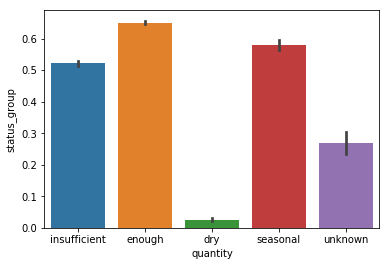

In [30]:
sns.barplot(x=train[feature], 
            y=train['status_group']=='functional');

In [32]:
X_train[feature].head(15)

43360    insufficient
7263           enough
2486     insufficient
313            enough
52726          enough
8558     insufficient
2559     insufficient
54735          enough
25763          enough
44540          enough
28603             dry
4372     insufficient
30666    insufficient
6431           enough
57420    insufficient
Name: quantity, dtype: object

### [One Hot Encoding](http://contrib.scikit-learn.org/categorical-encoding/onehot.html)

> Onehot (or dummy) coding for categorical features, produces one feature per category, each binary.

Warning: May run slow, or run out of memory, with high cardinality categoricals!

In [33]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train[[feature]])
print(f'{len(encoded.columns)} columns')
encoded.head()

5 columns


,quantity_insufficient,quantity_enough,quantity_dry,quantity_seasonal,quantity_unknown
43360,1,0,0,0,0
7263,0,1,0,0,0
2486,1,0,0,0,0
313,0,1,0,0,0
52726,0,1,0,0,0


### [Ordinal Encoding](http://contrib.scikit-learn.org/categorical-encoding/ordinal.html)

> Ordinal encoding uses a single column of integers to represent the classes. An optional mapping dict can be passed in; in this case, we use the knowledge that there is some true order to the classes themselves. Otherwise, the classes are assumed to have no true order and integers are selected at random.

In [35]:
encoder = ce.OrdinalEncoder()
encoded = encoder.fit_transform(X_train[[feature]])
print(f'1 column, {encoded[feature].nunique()} unique values')
encoded.head(15)

1 column, 5 unique values


,quantity
43360,1
7263,2
2486,1
313,2
52726,2
8558,1
2559,1
54735,2
25763,2
44540,2


# Assignment
- Start a clean notebook, or continue with yesterday's assignment notebook.
- Continue to participate in our Kaggle competition with the Tanzania Waterpumps data. 
- Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- Try a Random Forest Classifier. 
- Try Ordinal Encoding.
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Create visualizations and share on Slack.
- Read more about decision trees and tree ensembles. You can start with the links at the top & bottom of this notebook:

### Post-read links

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- [Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)
- [Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)